# Welcome!

This is going to be a random exploration of well data, mainly focusing on viz! Last year's talk would be a great intro into this talk. I won't go into as much detail into dataframe stuff, but will dive deeper into viz!

In [1]:
import pandas as pd
import numpy as np
import datetime

from glob import glob

In [2]:
cd drive/My Drive/T21_well_bonanza

[Errno 2] No such file or directory: 'drive/My Drive/T21_well_bonanza'
/Users/irene/Documents/sandpit/Others-repos/T21-well-data-bonanza/T21_well_bonanza


# prepping data input

Let's use glob to collect all of the excel files we would like to load in. The * before the .xls will grab every excel file in the folder. Use with caution! 

In [3]:
excel_files = glob("ca_geothermal_data/*.xls")
excel_files

['ca_geothermal_data/casad.xls',
 'ca_geothermal_data/heber.xls',
 'ca_geothermal_data/coso.xls',
 'ca_geothermal_data/geysers.xls',
 'ca_geothermal_data/saltons.xls']

In [4]:
df_prod = pd.DataFrame() # making a ?? hanging comment

print('Geothermal Fields:') # for new people, would it be useful to have your dataframe exploration and function in different cells? 

for z in range(len(excel_files)):
  field = excel_files[z].replace('ca_geothermal_data/','').split('.xls')[0]
  print(field)
  if field == 'casad' :
    df_ = pd.read_excel(excel_files[z], skiprows=5, usecols=[1,2,3,4])
  else :
    df_ = pd.read_excel(excel_files[z], skiprows=6, usecols=[1,2,3,4])

  df_.columns = df_.columns.str.replace(' ', '')

  if field == 'geysers' :
    df_.rename(columns={'Production(kilogramstimes1,000)': 'prod_MT', 
                       'Injection(kilogramstimes1,000)': 'injection_MT'}, inplace=True)
  else :
    df_.rename(columns={'Water(kilogramstimes1,000)': 'prod_MT', 
                       'Injection(kilogramstimes1,000)': 'injection_MT'}, inplace=True)
  
  df_.rename(columns={'Year': 'year', 
                      'Month': 'month'}, inplace=True)

  df_.replace('*', np.nan, inplace=True)
  df_ = df_.dropna(thresh=3)
  df_['field_name'] = field
  df_prod = df_prod.append(df_)

Geothermal Fields:
casad
heber
coso
geysers
saltons


The field names will need to be fixed, but good enough for now! Below is a map of the locations. 

<br>
<img src='https://drive.google.com/uc?id=17ccEKnfxE6MpDqITm_qdMMiQBijIJhBN'>

### QC'ing the data frame

In [5]:
df_prod.describe()

,year,month,prod_MT,injection_MT
count,2382.000000,2373.000000,2.382000e+03,2.371000e+03
mean,2000.042401,6.500211,4.363629e+06,3.182639e+06
std,12.559823,3.449787,2.832174e+06,2.437544e+06
min,1960.000000,1.000000,0.000000e+00,0.000000e+00
25%,1991.000000,4.000000,2.054466e+06,1.367841e+06
50%,2001.000000,7.000000,4.082838e+06,2.121199e+06
75%,2011.000000,9.000000,6.055216e+06,5.021998e+06
max,2021.000000,12.000000,1.267996e+07,1.020871e+07


Glad that the max month is 12, the years also make sense. 

In [6]:
df_prod.month.unique()

array([ 7.,  8.,  9., 10., 11., 12.,  1.,  2.,  3.,  4.,  5.,  6., nan])

Checking out the months in the dataset .... we will have to fix that nan later. 

Note that in the early years of operation, the Geysers production was only reported yearly. 

# cleaned data frame!

In [6]:
df_prod

,year,month,prod_MT,injection_MT,field_name
1,1984.0,7.0,2093.0,2077.0,casad
2,1984.0,8.0,715.0,715.0,casad
3,1984.0,9.0,17326.0,18084.0,casad
4,1984.0,10.0,52951.0,52951.0,casad
5,1984.0,11.0,1185043.0,894397.0,casad
...,...,...,...,...,...
461,2020.0,5.0,6258603.0,5446471.0,saltons
462,2020.0,6.0,11185769.0,9239716.0,saltons
463,2020.0,7.0,12045690.0,10050834.0,saltons
464,2020.0,8.0,11526198.0,9689633.0,saltons


### Creating a new columns

## Mass difference between production and injection

One thing I like to do is to understand the mass that is not injected back into the reservoir. 

In [7]:
df_prod['pro_minus_injection'] = df_prod.prod_MT.values - df_prod.injection_MT.values

Making a column of zero's for future datetime issues.

In [8]:
df_prod['day'] = 1

In [9]:
df_prod.describe()

,year,month,prod_MT,injection_MT,pro_minus_injection,day
count,2382.000000,2373.000000,2.382000e+03,2.371000e+03,2.371000e+03,2382.0
mean,2000.042401,6.500211,4.363629e+06,3.182639e+06,1.201226e+06,1.0
std,12.559823,3.449787,2.832174e+06,2.437544e+06,1.497463e+06,0.0
min,1960.000000,1.000000,0.000000e+00,0.000000e+00,-1.682461e+06,1.0
25%,1991.000000,4.000000,2.054466e+06,1.367841e+06,9.224900e+04,1.0
50%,2001.000000,7.000000,4.082838e+06,2.121199e+06,7.955160e+05,1.0
75%,2011.000000,9.000000,6.055216e+06,5.021998e+06,1.779935e+06,1.0
max,2021.000000,12.000000,1.267996e+07,1.020871e+07,8.134885e+06,1.0


# matplotlib

Let's do a few plots in matplotlib. Matplotlib is a great package for scientific plotting, that is ultimately changeable. 

In [11]:
import matplotlib.pyplot as plt

### histograms

This is a standard output of matplotlib histogram function. All it needs is an array, which is useful because under the hood our Pandas dataframe is an array.

/Users/irene/opt/anaconda3/envs/tank/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/irene/opt/anaconda3/envs/tank/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 28., 795., 612., 566., 166.,  76.,  37.,  53.,  23.,  15.]),
 array([-1682461. ,  -700726.4,   281008.2,  1262742.8,  2244477.4,
         3226212. ,  4207946.6,  5189681.2,  6171415.8,  7153150.4,
         8134885. ]),
 <a list of 10 Patch objects>)

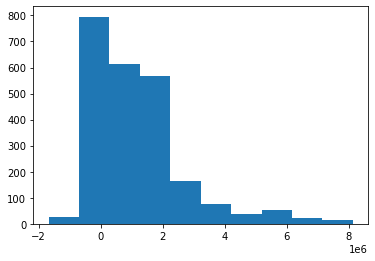

In [15]:
plt.hist(df_prod.pro_minus_injection.values)

# would be useful to label axis even in these quick plots. They are hard to parse without labels.

Nice! Let's add our widigets for the individual production and injection data. 

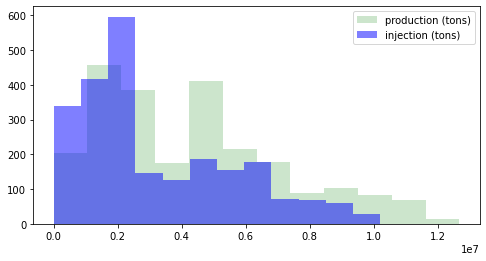

In [13]:
plt.figure(figsize=(8,4))
plt.hist(df_prod.prod_MT.values, bins=12, color='green', alpha=0.2, label='production (tons)')
plt.hist(df_prod.injection_MT.values, bins=12, color='blue', alpha=0.5, label='injection (tons)')
plt.legend()

To unpack what we did:


*   set the number of bins (bins=12)
*   specified color
*   added a legend
*   set opacity using alpha
*   set figure size



Looking at this from a resource operation perspective, there is some mass goes missing between production and injection.

Modern geothermal developments use re-injection to support reservoir pressure or as safe disposal of the geothermal brines because they contain potential environmental contaminates like arsenic and anatomy. This difference between production and injection is generated in two ways:

1. In geothermal power production where fluid is flashed (i.e. subjected sudden pressure drop to generate boiling) to generate steam that turns the turbine, some pure water is lost to atmosphere as steam. These power stations are called flash plants. Binary power run the geothermal brine though heat exchanges to heat a working fluid that then goes on to spin the turbine. The brine is in a close system and will therefore not lose mass to atmosphere.   

2. During power station maintenance or if there is an adverse operational event, geothermal brine inside the pipelines and power station may need to be discharged to containment ponds. Depending on the fluid chemistry and the local environmental regulations, operators may then dispose of this fluid into specialised cold brine injectors or to surface. Special injection wells are used for cold brine because it could reduce reservoir sustainability if injected in the wrong place. Some power stations have bioreactors to treat geothermal waters before they are discharged to surface (e.g. Wairakei in New Zealand). 

Check out [this paper](https://www.sciencedirect.com/science/article/abs/pii/S1364032110002121) to learn more about reinjection for geothermal resources. 

### line plot

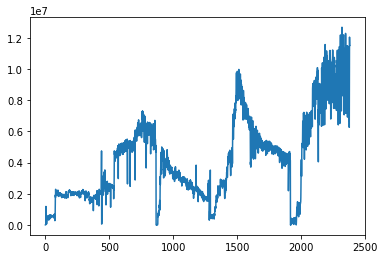

In [14]:
plt.plot(df_prod.prod_MT.values)

This plot does not really make sense, as the x index is just the index count. But it does point out you don't need to specify an x axis with plt.plot. 

Let's look at the production and injection data for just the [Salton Sea reservior](https://en.wikipedia.org/wiki/Imperial_Valley_Geothermal_Project) that hosts the Imperial Valley Geothermal Project.

_SIDE COMMENT FOR YOU... Most of these resources have several power plants on them. I'm assuming that you have managed to source the total mass-take and reinjection data. One nice thing to look at is the relationship between when power stations were commissioned and the steps in mass-take. There is a table of data on the wiki page and you could plot date against the MWe that was comissioned if you wanted to_

In [16]:
salton = df_prod[df_prod['field_name'] == 'saltons']

In [17]:
salton

,year,month,prod_MT,injection_MT,field_name,pro_minus_injection,day
1,1982.0,1.0,0.0,NaN,saltons,NaN,1
2,1982.0,2.0,23102.0,22711.0,saltons,391.0,1
3,1982.0,3.0,31557.0,30261.0,saltons,1296.0,1
4,1982.0,4.0,3908.0,2829.0,saltons,1079.0,1
5,1982.0,5.0,21273.0,19565.0,saltons,1708.0,1
...,...,...,...,...,...,...,...
461,2020.0,5.0,6258603.0,5446471.0,saltons,812132.0,1
462,2020.0,6.0,11185769.0,9239716.0,saltons,1946053.0,1
463,2020.0,7.0,12045690.0,10050834.0,saltons,1994856.0,1
464,2020.0,8.0,11526198.0,9689633.0,saltons,1836565.0,1


Let's make the date something senseable. Pandas handles dates pretty well once you get a hang of it. 

In [18]:
foo = salton[['year', 'month', 'day']].astype('int64')
salton['date'] = pd.to_datetime(foo)

salton.dtypes # note the dtypes

ipykernel_launcher:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


year                          float64
month                         float64
prod_MT                       float64
injection_MT                  float64
field_name                     object
pro_minus_injection           float64
day                             int64
date                   datetime64[ns]
dtype: object

In [19]:
salton.head()

,year,month,prod_MT,injection_MT,field_name,pro_minus_injection,day,date
1,1982.0,1.0,0.0,NaN,saltons,NaN,1,1982-01-01
2,1982.0,2.0,23102.0,22711.0,saltons,391.0,1,1982-02-01
3,1982.0,3.0,31557.0,30261.0,saltons,1296.0,1,1982-03-01
4,1982.0,4.0,3908.0,2829.0,saltons,1079.0,1,1982-04-01
5,1982.0,5.0,21273.0,19565.0,saltons,1708.0,1,1982-05-01


Let's drop row 1 since it does not have production or injection data.

In [18]:
salton = salton.drop(1)

In [19]:
salton.head(3)

,year,month,prod_MT,injection_MT,field_name,pro_minus_injection,day,date
2,1982.0,2.0,23102.0,22711.0,saltons,391.0,1,1982-02-01
3,1982.0,3.0,31557.0,30261.0,saltons,1296.0,1,1982-03-01
4,1982.0,4.0,3908.0,2829.0,saltons,1079.0,1,1982-04-01


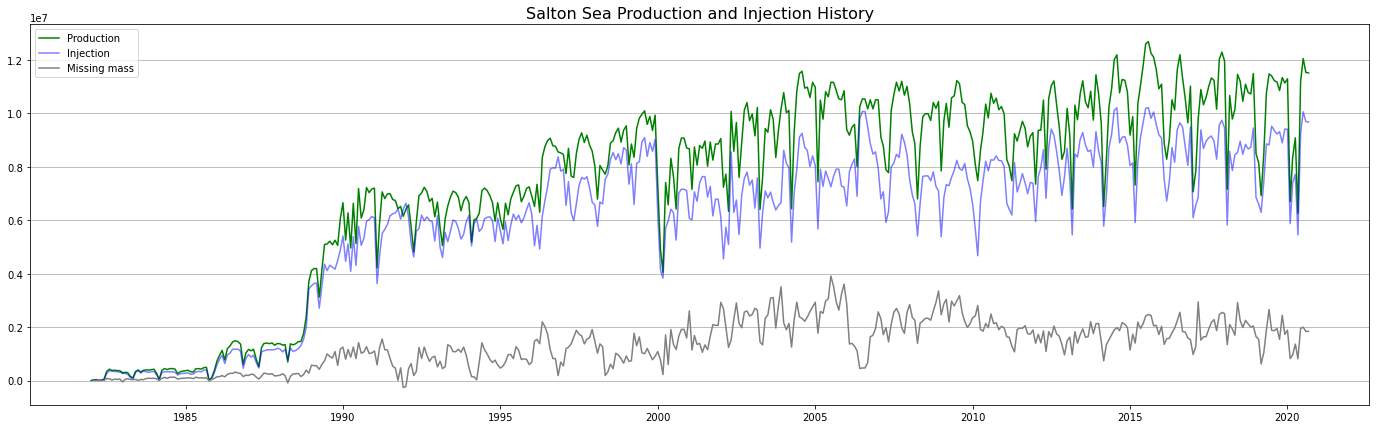

In [27]:
plt.figure(figsize=(24,7))
plt.title('Salton Sea Reservoir (Imperial Valley Geothermal Project) Production and Injection History', size=16)
plt.plot(salton.date, salton.prod_MT, color='green', label='Production')
plt.plot(salton.date, salton.injection_MT, color='blue', alpha=0.5, label='Injection')

plt.plot(salton.date, salton.pro_minus_injection, color='grey', label='Missing mass') # I found it really hard to parse this plotted as a negitive

plt.legend()
plt.grid(axis='y')

The first few years had low-ish production and production of geothermal brine increases as more power stations are added at surface. 

_This would be a good place to include the power plant data_

This looks oddly seasonal, lets dive into a subset.

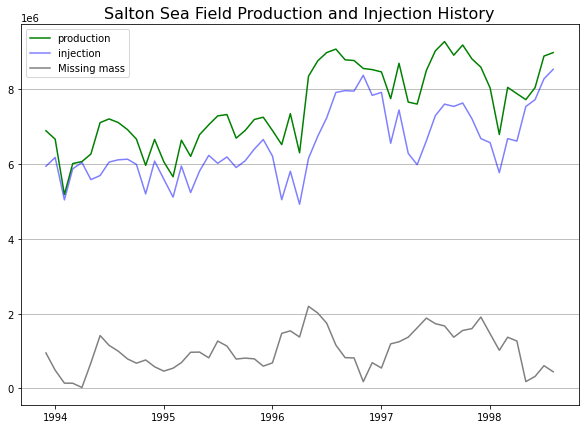

In [26]:
plt.figure(figsize=(10,7))
plt.title('Seasonal Cycles in Production and Injection', size=16)
plt.plot(salton.date[143:200], salton.prod_MT[143:200], color='green', label='production')
plt.plot(salton.date[143:200], salton.injection_MT[143:200], color='blue', alpha=0.5, label='injection')
plt.plot(salton.date[143:200], salton.pro_minus_injection[143:200], color='grey', label='Missing mass')
plt.legend()
plt.grid(axis='y')

Looks like maintance around winter. Might coinside with lowest energy use in the state due to more AC use than heating in California. Neat.

Geothermal is usually considered 'baseload' energy because the power stations and wells are not turned on and off in response to demand, as happened in a coal or gas fired power station or in a hydro dam. There are three main reasons why you do not want to turn geothermal power stations on and off:
1. Thermally cycling the steel and casing connections in geothermal wells damages them and may cause casing breaks
2. Minerals can quickly precipitate out of geothermal brine so if you let it cool in pipelines they become plugged
3. High temperature geothermal wells (like those at the Salton Sea) flow because of the energy of boiling. While many wells will naturally boil and self-discharge once fully heated, some wells can be tricky and expensive to start.

Extraction and associated generation can be varied, however, in response to demand. This can be seen here for the Salton Sea where energy demand is driven by air conditioning. Power station efficiency is also impacted by seasons, especially places where there is a cool winter. Cool weather improves the efficiency of cooling towers in both flash and binary technology and enable greater energy conversion for the given mass produced. 

### scatter

Same theme, let's dive into the seasonality using scatter plots.

Text(0.5, 0, 'Months')

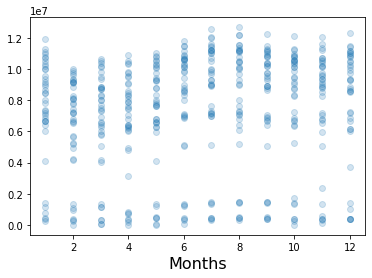

In [22]:
plt.scatter(salton.month, salton.prod_MT, alpha=0.2)
plt.xlabel('Months', size=16)

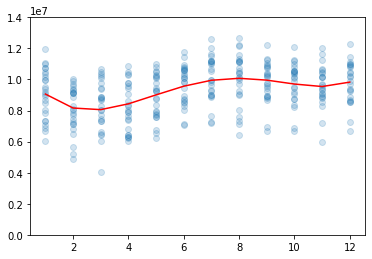

In [23]:
x = salton.month[143:440]
y = salton.prod_MT[143:440]
z = salton.injection_MT[143:440]

plt.scatter(x, y, alpha=0.2)
plt.ylim([-1e2, 1.4e7])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 5))(np.unique(x)), color='r')

Looks like Feb-March has the lowest production. A 5th order curve is probably a bit much _(I'm not sure what you mean by this... ug I is geologist)_. Feel free to play around with the polyfit!

### bar chart

Let's use the same variable as above, but as a bar chart.

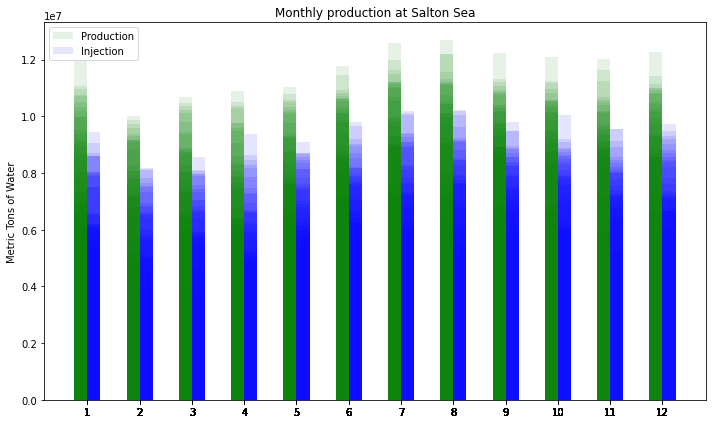

In [24]:

width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, y, width, color = 'green', alpha=0.1, label='Production')
rects2 = ax.bar(x + width/2, z, width, color = 'blue', alpha=0.1, label='Injection')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Tons of Water')
ax.set_title('Monthly production at Salton Sea')
ax.set_xticks(x)
ax.legend()

fig.tight_layout()

plt.show()

While this does communcate some of the yearly variablity, does not do a great job.

# seaborn

### violin plot

In [25]:
import seaborn as sns

Let's do a violin plot!

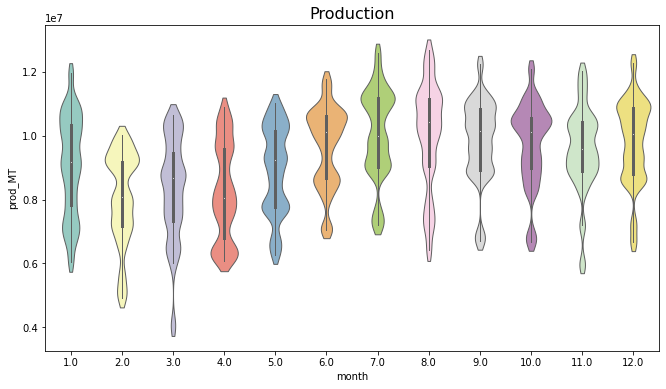

In [26]:
f, ax = plt.subplots(figsize=(11, 6))

plt.title('Production', size = 16)
sns.violinplot(x=x, y=y, palette="Set3", bw=.2, cut=1, linewidth=1)

Using a violin plot, it's easier to see the long tails, and that most of the data is pretty consistent. 

### line plot

In [27]:
salton

,year,month,prod_MT,injection_MT,field_name,pro_minus_injection,day,date
2,1982.0,2.0,23102.0,22711.0,saltons,391.0,1,1982-02-01
3,1982.0,3.0,31557.0,30261.0,saltons,1296.0,1,1982-03-01
4,1982.0,4.0,3908.0,2829.0,saltons,1079.0,1,1982-04-01
5,1982.0,5.0,21273.0,19565.0,saltons,1708.0,1,1982-05-01
6,1982.0,6.0,45043.0,42210.0,saltons,2833.0,1,1982-06-01
...,...,...,...,...,...,...,...,...
461,2020.0,5.0,6258603.0,5446471.0,saltons,812132.0,1,2020-05-01
462,2020.0,6.0,11185769.0,9239716.0,saltons,1946053.0,1,2020-06-01
463,2020.0,7.0,12045690.0,10050834.0,saltons,1994856.0,1,2020-07-01
464,2020.0,8.0,11526198.0,9689633.0,saltons,1836565.0,1,2020-08-01


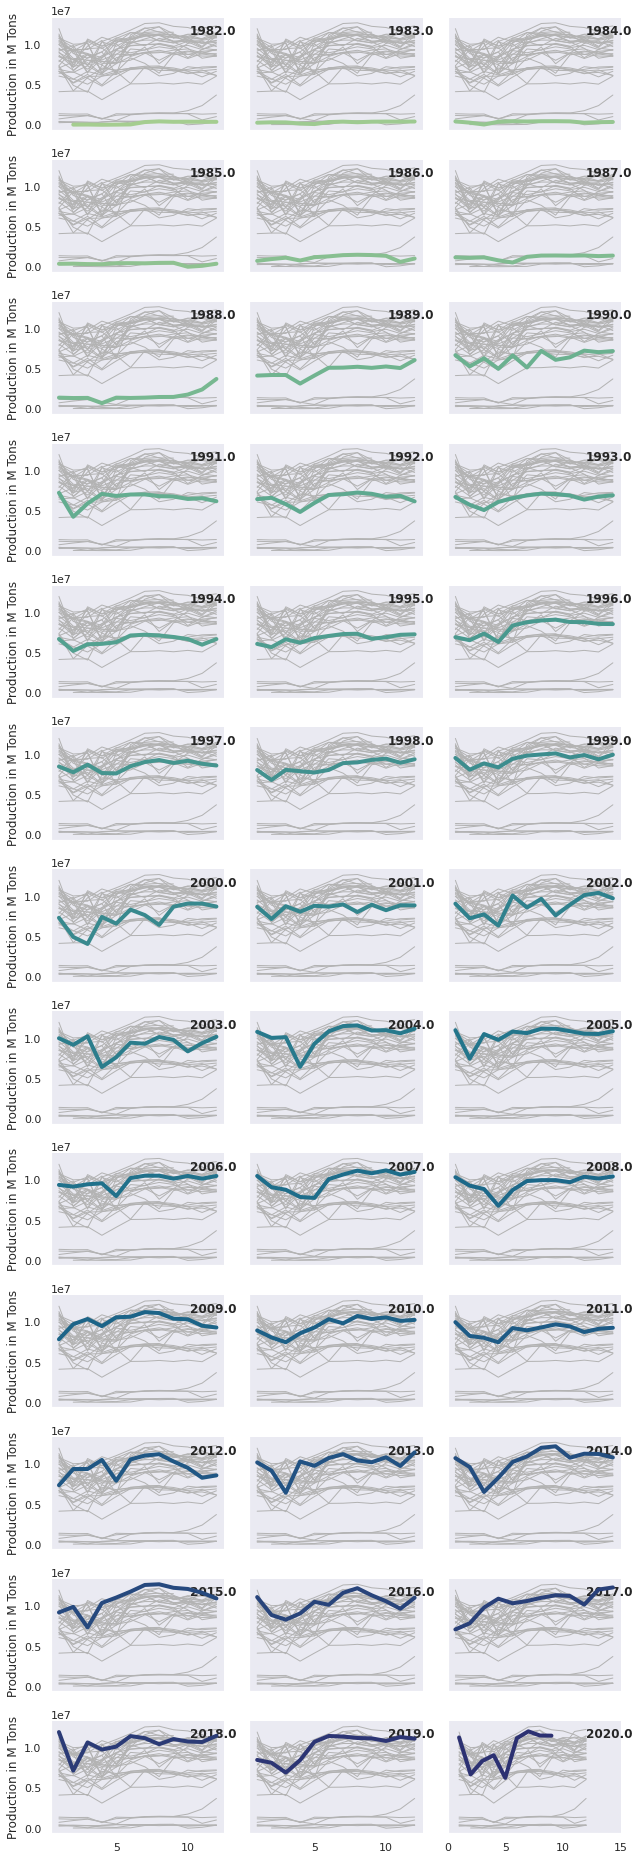

In [28]:
sns.set_theme(style="dark")

# Plot each year's time series in its own facet
g = sns.relplot(
    data=salton,
    x="month", y="prod_MT", col="year", hue="year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=salton, x="month", y="prod_MT", units="year",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Production in M Tons")
g.tight_layout()

.... don't know why the last plot has ~15 months. 

### scatter

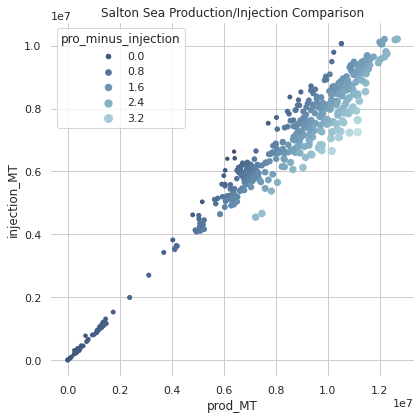

In [29]:
sns.set_theme(style="whitegrid")

# Load the example diamonds dataset

f, ax = plt.subplots(figsize=(6.5, 6.5))

plt.title('Salton Sea Production/Injection Comparison')
sns.despine(f, left=True, bottom=True)

sns.scatterplot(x=salton.prod_MT, 
                y=salton.injection_MT,
                hue=salton.pro_minus_injection*10000, 
                size=salton.pro_minus_injection*10000,
                palette="ch:r=-.2,d=.3_r", 
                linewidth=0, 
                ax=ax)

### scatterplot matrix

Let's make a new, smaller dataframe of our entire dataset.

In [30]:
df_scatter = df_prod[['prod_MT', 'injection_MT', 'field_name']]
df_scatter

,prod_MT,injection_MT,field_name
1,2093.0,2077.0,casad
2,715.0,715.0,casad
3,17326.0,18084.0,casad
4,52951.0,52951.0,casad
5,1185043.0,894397.0,casad
...,...,...,...
461,6258603.0,5446471.0,saltons
462,11185769.0,9239716.0,saltons
463,12045690.0,10050834.0,saltons
464,11526198.0,9689633.0,saltons


<Figure size 648x648 with 0 Axes>

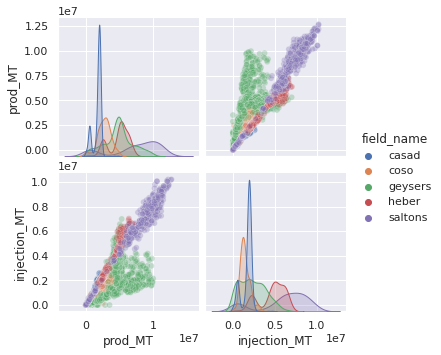

In [31]:
plt.figure(figsize=(9,9))
sns.set_theme(style="darkgrid")


sns.pairplot(df_scatter,
             hue='field_name',
             plot_kws={'alpha':0.3})

The production to injection should roughly be 1 to 1, to maintain subsurface mass balace. Check out Geysers!

### THIS PLOT IS REALLY COOL!

_NOTES FOR YOU... The Geysers is different from the others because it is a dry steam reservoir. In the early years of development is experienced dramatic decline. Now they take treated waste water from Santa Rosa in inject this into the reservoir to sustain the pressure. It would look really amazing if you split the data for before the wastewater injection strategy was implemented and after. Just depends on how far you are interested in going with this. I'm not sure why heber has a slightly different trend with time as I haven't spent time with this resource. Could find out if needed._ 

# plotly express

plotly express is a wrapper for plotly, which makes syntax a bit easier to handle. 

In [30]:
import plotly.graph_objs as go
import plotly.express as px

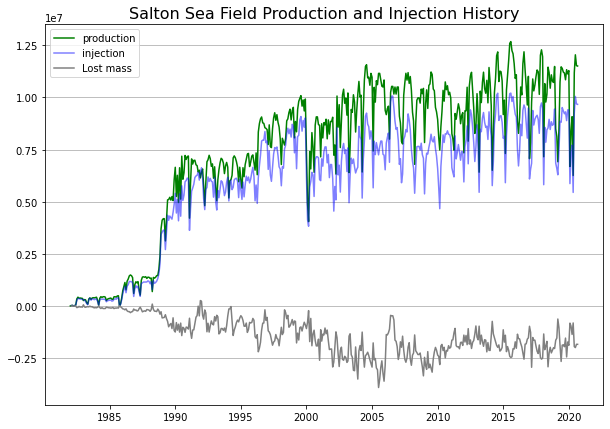

In [28]:
# again I find the negitive mass loss hard to parse

plt.figure(figsize=(10,7))
plt.title('Salton Sea Field Production and Injection History', size=16)
plt.plot(salton.date, salton.prod_MT, color='green', label='production')
plt.plot(salton.date, salton.injection_MT, color='blue', alpha=0.5, label='injection')

plt.plot(salton.date, -1*salton.pro_minus_injection, color='grey', label='Lost mass')
plt.legend()
plt.grid(axis='y')

In [31]:


# Plotly figure 1
fig = px.line(salton, x='date', y='prod_MT',
              hover_name='prod_MT')

fig.update_traces(line_color='#456987')
fig.update_layout(title='Production & Injection' , showlegend=True)

# Plotly figure 2
fig2 = go.Figure(fig.add_traces(
                 data=px.line(salton, x='date', y='injection_MT',
                              hover_name="injection_MT")._data))
fig2.update_layout(title='Production & Injection' , showlegend=True)

fig2.show()